In [ ]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-3zae49wh
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-3zae49wh
  Resolved https://github.com/tensorflow/docs to commit 40881b6e9c65d3cd164b391de055aeb60d2f51af
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.5.26.9808-py3-none-any.whl size=183623 sha256=ca410dac3a39580be375cb820378cceae5ae7ca734762043a8fed2e75e46b019
  Stored in directory: /tmp/pip-ephem-wheel-cache-0q6l3x0x/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


# Basic GAN

In [ ]:
import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

In [ ]:
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28,28,1)
train_images = (train_images - 127.5)/127.5


11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [ ]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape == (None, 7,7,256)

  model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7,7,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14,14,64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation= 'tanh'))
  assert model.output_shape == (None, 28,28,1)

  return model

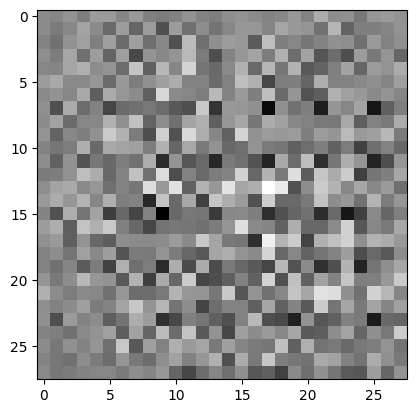

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0,:,:,0], cmap='gray')

In [ ]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same',
                          input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5,5), strides = (2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [ ]:
discriminator = make_discriminator_model()

decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00095534]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer= generator_optimizer,
                                 discriminator_optimizer= discriminator_optimizer,
                                 generator= generator,
                                 discriminator= discriminator)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

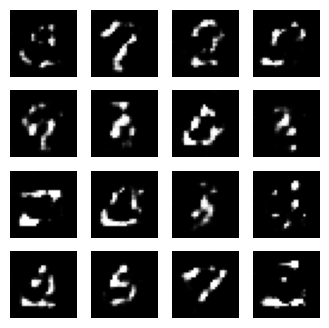

Time for epoch 18 is 11.961142539978027 sec


In [ ]:
train(train_dataset, EPOCHS)


In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

# SRGAN

In [ ]:
import math
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

In [ ]:
dataset_url = 'http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz'
data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSDS500/data")

In [ ]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size = batch_size,
    image_size=(crop_size, crop_size),
    validation_split = 0.2,
    subset="training",
    seed=1337,
    label_mode=None
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size = batch_size,
    image_size=(crop_size, crop_size),
    validation_split = 0.2,
    subset="validation",
    seed=1337,
    label_mode=None
)

In [ ]:
def scaling(input_image):
  input_image = input_image/255.0
  return input_image

train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

In [ ]:
for batch in train_ds.take(1):
  for img in batch:
    display(array_to_img(img))

In [ ]:
dataset = os.path.join(root_dir, "images")
test_path = os.path.join(dataset, "test")
test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

In [ ]:
def process_input(input, input_size, upscale_factor):
  input = tf.image.rgb_to_yuv(input)
  last_dimension_axis = len(input.shape)-1
  y,u,v = tf.split(input,3,axis=last_dimension_axis)
  return tf.image.resize(y, [input_size, input_size], method='area')

In [ ]:
def process_target(input):
  input = tf.image.rgb_to_yuv(input)
  last_dimension_axis = len(input.shape)-1
  y,u,v = tf.split(input,3,axis=last_dimension_axis)
  return y

In [ ]:
train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))

)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

In [ ]:
for batch in train_ds.take(1):
  for img in batch[0]:
    display(array_to_img(img))
  for img in batch[1]:
    display(array_to_img(img))

In [ ]:
def get_model(upscale_factor=3, channels=1):
  conv_args={
      "activation":"relu",
      "kernel_initializer": "Orthogonal",
      "padding": "same",
  }
  inputs = keras.Input(shape=(None, None, channels))
  x = layers.Conv2D(64, 5, **conv_args)(inputs)
  x = layers.Conv2D(64, 3, **conv_args)(x)
  x = layers.Conv2D(32, 3, **conv_args)(x)
  x = layers.Conv2D(channels*(upscale_factor**2), 3, **conv_args)(x)
  outputs = tf.nn.depth_to_space(x, upscale_factor)

  return keras.Model(inputs, outputs)

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import PIL

In [ ]:
def plot_results(img, prefix, title):
  img_array = img_to_array(img)
  img_array = img_array.astype("float32")/255.0

  fig, ax = plt.subplots()
  im = ax.imshow(img_array[::-1], origin="lower")
  plt.title(title)
  axins = zoomed_inset_axes(ax,2,loc=2)
  axins.imshow(img_array[::-1], origin="lower")

  x1,x2,y1,y2 = 200,300,100,200
  axins.set_xlim(x1,x2)
  axins.set_ylim(y1,y2)

  plt.yticks(visible=False)
  plt.xticks(visible=False)

  mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
  plt.savefig(str(prefix) + "-" +title+".png")
  plt.show()

In [ ]:
def get_lowres_image(img, upscale_factor):
  return img.resize(
      (img.size[0]// upscale_factor, img.size[1]// upscale_factor),
      PIL.Image.BICUBIC,
  )

In [ ]:
def upscale_image(model, img):
  ycbcr = img.convert("YCbCr")
  y, cb, cr = ycbcr.split()
  y = img_to_array(y)
  y = y.astype("float32")/255.0

  input = np.expand_dims(y,axis=0)
  out = model.predict(input)

  out_img_y = out[0]
  out_img_y *= 255.0

  out_img_y = out_img_y.clip(0,255)
  out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
  out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
  out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
  out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
  out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
      "RGB"
  )
  return out_img

In [ ]:
class ESPCNCallback(keras.callbacks.Callback):
  def __init__(self):
    super(ESPCNCallback,self).__init__()
    self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

  def on_epoch_begin(self, epoch, logs=None):
    self.psnr = []

  def on_epoch_end(self, epoch, logs=None):
    print("Mean PSNR ofr epoch: %.2f" % (np.mean(self.psnr)))

    if epoch %20 == 0:
      prediction = upscale_image(self.model, self.test_img)
      plot_results(prediction, "epoch-" + str(epoch), "prediction")

  def on_test_batch_end(self, batch, logs=None):
    self.psnr.append(10*math.log10(1/logs['loss']))

In [ ]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss",
                                                        patience= 10)

checkpoint_filepath = "/tmp/checkpoint"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True
)
model= get_model(upscale_factor=upscale_factor, channels=1)

model.summary()
callbacks = [ESPCNCallback(), early_stopping_callback,model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate = 0.001)

In [ ]:
epochs=50

model.compile(
    optimizer=optimizer, loss=loss_fn,
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)
model.load_weights(checkpoint_filepath)